In [1]:
import argparse, os, time
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter, FuncFormatter
import seaborn as sns
from collections import defaultdict
from tqdm import tqdm
import pickle
from ethnicseer import EthnicClassifier

In [2]:
indivs20 = "./data/CampaignFin20/indivs20.txt"
indivs22 = "./data/CampaignFin22/indivs22.txt"
names_csv = "./data/wiki_name_race.csv"
model_path = "./models/wiki_name_classifier.pkl"

In [3]:
def preprocess_name(name):
    parts = name.strip().split()
    first_name = parts[0].lower() if len(parts) > 0 else ""
    last_name = parts[-1].lower() if len(parts) > 1 else ""
    
    f4_first = first_name[:4] if len(first_name) >= 4 else first_name
    l4_first = first_name[-4:] if len(first_name) >= 4 else first_name
    f4_last = last_name[:4] if len(last_name) >= 4 else last_name
    l4_last = last_name[-4:] if len(last_name) >= 4 else last_name
    
    n_sub_names = len(parts)
    has_dash = any('-' in part for part in parts)
    
    return {
        'first_name': first_name,
        'last_name': last_name,
        'f4_first': f4_first,
        'l4_first': l4_first,
        'f4_last': f4_last,
        'l4_last': l4_last,
        'n_sub_names': min(n_sub_names, 4),
        'has_dash': int(has_dash)
    }


In [4]:
def build_name_stats(df, name_col='name', ethnicity_col='ethnic'):
    first_name_stats = defaultdict(lambda: defaultdict(int))
    last_name_stats = defaultdict(lambda: defaultdict(int))
    f4_first_stats = defaultdict(lambda: defaultdict(int))
    l4_first_stats = defaultdict(lambda: defaultdict(int))
    f4_last_stats = defaultdict(lambda: defaultdict(int))
    l4_last_stats = defaultdict(lambda: defaultdict(int))
    
    for _, row in df.iterrows():
        name_info = preprocess_name(row[name_col])
        ethnicity = row[ethnicity_col]
        
        first_name_stats[name_info['first_name']][ethnicity] += 1
        last_name_stats[name_info['last_name']][ethnicity] += 1
        f4_first_stats[name_info['f4_first']][ethnicity] += 1
        l4_first_stats[name_info['l4_first']][ethnicity] += 1
        f4_last_stats[name_info['f4_last']][ethnicity] += 1
        l4_last_stats[name_info['l4_last']][ethnicity] += 1
    
    return {
        'first_name_stats': first_name_stats,
        'last_name_stats': last_name_stats,
        'f4_first_stats': f4_first_stats,
        'l4_first_stats': l4_first_stats,
        'f4_last_stats': f4_last_stats,
        'l4_last_stats': l4_last_stats
    }


In [5]:
def create_features(name, stats, cats=['ind', 'not']):
    name_info = preprocess_name(name)
    features = {}
    
    for eth in cats:
        fn_counts = stats['first_name_stats'][name_info['first_name']]
        total_fn = sum(fn_counts.values())
        features[f'probability_{eth}_first_name'] = fn_counts.get(eth, 0) / (total_fn + 1)
        
        ln_counts = stats['last_name_stats'][name_info['last_name']]
        total_ln = sum(ln_counts.values())
        features[f'probability_{eth}_last_name'] = ln_counts.get(eth, 0) / (total_ln + 1)
        
        f4f_counts = stats['f4_first_stats'][name_info['f4_first']]
        total_f4f = sum(f4f_counts.values())
        features[f'probability_{eth}_first_name_f4'] = f4f_counts.get(eth, 0) / (total_f4f + 1)
        
        l4f_counts = stats['l4_first_stats'][name_info['l4_first']]
        total_l4f = sum(l4f_counts.values())
        features[f'probability_{eth}_first_name_l4'] = l4f_counts.get(eth, 0) / (total_l4f + 1)
        
        f4l_counts = stats['f4_last_stats'][name_info['f4_last']]
        total_f4l = sum(f4l_counts.values())
        features[f'probability_{eth}_last_name_f4'] = f4l_counts.get(eth, 0) / (total_f4l + 1)
        
        l4l_counts = stats['l4_last_stats'][name_info['l4_last']]
        total_l4l = sum(l4l_counts.values())
        features[f'probability_{eth}_last_name_l4'] = l4l_counts.get(eth, 0) / (total_l4l + 1)
        
        features[f'best_evidence_{eth}'] = max(
            features[f'probability_{eth}_first_name'],
            features[f'probability_{eth}_last_name']
        )
    
    features['dash_indicator'] = name_info['has_dash']
    features['n_sub_names'] = name_info['n_sub_names']
    
    return features


In [6]:
def is_indistinguishable(name, stats, threshold=0.15):
    
    name_info = preprocess_name(name)
    features = create_features(name, stats)
    
    cats = sorted(stats['first_name_stats'][name_info['first_name']].keys())
    psi = {cat: features[f'probability_{cat}_first_name'] for cat in cats}
    phi = {cat: features[f'probability_{cat}_last_name'] for cat in cats}
    
    indistinguishable_pairs = []
    
    for i, r1 in enumerate(cats):
        for r2 in cats[i+1:]:
            
            condition1 = (abs(psi[r1] - psi[r2]) <= threshold and 
                         abs(phi[r1] - phi[r2]) <= threshold)
            
            max_psi = max(psi.values())
            max_phi = max(phi.values())
            condition2 = (max_psi - min(psi[r1], psi[r2]) <= threshold and 
                         max_phi - min(phi[r1], phi[r2]) <= threshold)
            
            if condition1 and condition2:
                indistinguishable_pairs.append(f"{r1}-{r2}")
    
    return indistinguishable_pairs if indistinguishable_pairs else None


In [7]:
def handle_indistinguishables(df, stats, name_col='name'):
    
    df['indistinguishable'] = None
    
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        name = row[name_col]
        indistinguishable = is_indistinguishable(name, stats)
        
        if indistinguishable:
            df.at[idx, 'indistinguishable'] = ','.join(indistinguishable)
    
    return df


In [8]:
def extract_names(path):
    start = time.time()
    print("Extracting unique names...")

    unique_names_df = (
        pl.scan_csv(
            path,
            separator=',', 
            quote_char='|', 
            encoding='utf8-lossy', 
            has_header=False,
            new_columns=['dummy1', 'dummy2', 'contrib_id', 'name'],  # Only define up to the name column
            schema_overrides={'name': pl.Utf8},
            ignore_errors=True
        )
        .filter(
            pl.col("contrib_id").is_not_null()
            & pl.col("contrib_id").str.strip_chars().ne("")
        )
        .select(['name'])
        .with_columns(pl.col('name').str.to_uppercase().str.strip_chars())
        .unique()
        .collect()
    )

    elapsed = time.time() - start
    print(f"Found {len(unique_names_df):,} in {elapsed:.2f}s")
    return unique_names_df

In [9]:
def classify_names(df, model_path, threshold=0.01):
    
    with open(model_path, 'rb') as file:
        model = pickle.load(file)
    names_list = df['name'].drop_nulls().to_list()
    
    df = pd.read_csv("./data/wiki_name_race.csv")
    df["ethnic"] = df["race"].apply(lambda x: x.split(",")[-1])
    df["ethnic"] = df["ethnic"].apply(lambda x: "ind" if x == "IndianSubContinent" else "not")
    df["name"] = df['name_first'].str.cat(df[['name_middle', 'name_last', 'name_suffix']], sep=' ', na_rep='')
    df = df[["name", "ethnic"]]
    df = df.dropna()
    
    stats = build_name_stats(df, "name", "ethnic")
    X_new = np.array([list(create_features(name, stats).values()) for name in names_list])
    
    y_probs = model.predict_proba(X_new)[:, 1]
    y_pred_adjusted = (y_probs <= threshold).astype(int)
    print(pd.Series(y_pred_adjusted).value_counts())
    is_indian_predictions = [bool(pred) for pred in y_pred_adjusted]
    
    prob_df = pd.DataFrame({"name": names_list, "probs": y_probs})
    prob_df.to_csv("./output/df_wiki_probs.csv", index=False)
    
    pred_df = pl.DataFrame({'name': names_list, 'is_indian': is_indian_predictions})
    pred_df_lazy = pred_df.lazy()

    print("Name classification complete.")
    return pred_df, pred_df_lazy

In [10]:
names = extract_names(indivs20)
preds, preds_lazy = classify_names(names, model_path)

Extracting unique names...
Found 3,579,817 in 19.33s
0    3579539
1        278
Name: count, dtype: int64
Name classification complete.


In [11]:
preds["is_indian"].value_counts()

is_indian,count
bool,u32
false,3579539
true,278


In [13]:
lf = (
        pl.scan_csv(
            indivs20,
            separator=',', 
            quote_char='|', 
            encoding='utf8-lossy', 
            has_header=False,
            # Only define the columns we actually use
            new_columns=['dummy1', 'dummy2', 'contrib_id', 'name', 'recip_id', 
                        'dummy3', 'dummy4', 'dummy5', 'dummy6', 'amount', 
                        'dummy7', 'city', 'state', 'dummy8', 'recipcode'],
            schema_overrides={'amount': pl.Float64, 'name': pl.Utf8, 'state': pl.Utf8, 'city': pl.Utf8},
            ignore_errors=True
        )
        .select(['contrib_id', 'name', 'recip_id', 'amount', 'city', 'state', 'recipcode'])
        # Join with name_lookup to get is_indian
        .with_columns(pl.col('name').str.to_uppercase().str.strip_chars())
        .join(preds_lazy, on='name', how='left')
        .filter(~pl.col('amount').is_null())
    )

In [14]:
df = lf.collect()
print(df.head(10))

shape: (10, 8)
┌──────────────┬──────────────┬───────────┬─────────┬──────────────┬───────┬───────────┬───────────┐
│ contrib_id   ┆ name         ┆ recip_id  ┆ amount  ┆ city         ┆ state ┆ recipcode ┆ is_indian │
│ ---          ┆ ---          ┆ ---       ┆ ---     ┆ ---          ┆ ---   ┆ ---       ┆ ---       │
│ str          ┆ str          ┆ str       ┆ f64     ┆ str          ┆ str   ┆ str       ┆ bool      │
╞══════════════╪══════════════╪═══════════╪═════════╪══════════════╪═══════╪═══════════╪═══════════╡
│ p0004869853  ┆ LONNBERG,    ┆ C00721712 ┆ 10000.0 ┆ SAN          ┆ CA    ┆ DP        ┆ false     │
│              ┆ CARL         ┆           ┆         ┆ FRANCISCO    ┆       ┆           ┆           │
│ k0001516259  ┆ LOVO, MARIO  ┆ N00044240 ┆ 250.0   ┆ CORAL GABLES ┆ FL    ┆ DL        ┆ false     │
│ h3003526289  ┆ LOGUE,       ┆ C00401224 ┆ 5.0     ┆ BARRINGTON   ┆ IL    ┆ PI        ┆ false     │
│              ┆ KATHERINE    ┆           ┆         ┆              ┆       ┆

In [15]:
print(df.sort("amount", descending=True))

shape: (37_145_943, 8)
┌─────────────┬─────────────┬───────────┬─────────────┬────────────┬───────┬───────────┬───────────┐
│ contrib_id  ┆ name        ┆ recip_id  ┆ amount      ┆ city       ┆ state ┆ recipcode ┆ is_indian │
│ ---         ┆ ---         ┆ ---       ┆ ---         ┆ ---        ┆ ---   ┆ ---       ┆ ---       │
│ str         ┆ str         ┆ str       ┆ f64         ┆ str        ┆ str   ┆ str       ┆ bool      │
╞═════════════╪═════════════╪═══════════╪═════════════╪════════════╪═══════╪═══════════╪═══════════╡
│ U0000003704 ┆ BLOOMBERG,  ┆ N00029349 ┆ 1.25e8      ┆ NEW YORK   ┆ NY    ┆ DL        ┆ false     │
│ 1           ┆ MICHAEL R   ┆           ┆             ┆            ┆       ┆           ┆           │
│ U0000003704 ┆ BLOOMBERG,  ┆ N00029349 ┆ 8.5e7       ┆ NEW YORK   ┆ NY    ┆ DL        ┆ false     │
│ 1           ┆ MICHAEL R   ┆           ┆             ┆            ┆       ┆           ┆           │
│ U0000003704 ┆ BLOOMBERG,  ┆ N00029349 ┆ 8.5e7       ┆ NEW YORK   ┆

In [16]:
top_donors = (
    df.group_by("contrib_id")
    .agg(
        pl.col("name").first().alias("name"),
        pl.col("amount").sum().alias("total_donated"),
        pl.col("amount").count().alias("donation_count"),
        pl.col("amount").mean().alias("avg_donation"),
        pl.col("is_indian").first().alias("is_indian")
    )
    .sort("total_donated", descending=True)
)
print(top_donors.head(10))

shape: (10, 6)
┌──────────────┬──────────────────────┬───────────────┬────────────────┬───────────────┬───────────┐
│ contrib_id   ┆ name                 ┆ total_donated ┆ donation_count ┆ avg_donation  ┆ is_indian │
│ ---          ┆ ---                  ┆ ---           ┆ ---            ┆ ---           ┆ ---       │
│ str          ┆ str                  ┆ f64           ┆ u32            ┆ f64           ┆ bool      │
╞══════════════╪══════════════════════╪═══════════════╪════════════════╪═══════════════╪═══════════╡
│              ┆ FOR AMERICA, AMY     ┆ 1.2556e9      ┆ 27780          ┆ 45197.813535  ┆ null      │
│ U00000037041 ┆ BLOOMBERG, MICHAEL   ┆ 1.1277e9      ┆ 960            ┆ 1.1747e6      ┆ false     │
│ U00000036521 ┆ STEYER, THOMAS F     ┆ 3.79061294e8  ┆ 779            ┆ 486599.863928 ┆ false     │
│ U00000046841 ┆ MELLON, TIMOTHY      ┆ 4.5133555e7   ┆ 23             ┆ 1.9623e6      ┆ false     │
│ U0000000310A ┆ ADELSON, MIRIAM O DR ┆ 4.497155e7    ┆ 134            ┆ 335

In [17]:
print(df.filter(pl.col("is_indian") == True))

shape: (1_491, 8)
┌──────────────┬───────────────┬───────────┬────────┬──────────────┬───────┬───────────┬───────────┐
│ contrib_id   ┆ name          ┆ recip_id  ┆ amount ┆ city         ┆ state ┆ recipcode ┆ is_indian │
│ ---          ┆ ---           ┆ ---       ┆ ---    ┆ ---          ┆ ---   ┆ ---       ┆ ---       │
│ str          ┆ str           ┆ str       ┆ f64    ┆ str          ┆ str   ┆ str       ┆ bool      │
╞══════════════╪═══════════════╪═══════════╪════════╪══════════════╪═══════╪═══════════╪═══════════╡
│ r0004731745  ┆ PEREZ DURAN,  ┆ C00010603 ┆ 414.0  ┆ WIEN         ┆ ZZ    ┆ DP        ┆ true      │
│              ┆ FERNANDO      ┆           ┆        ┆              ┆       ┆           ┆           │
│ k0002015078  ┆ MILLER MD,    ┆ N00043581 ┆ 300.0  ┆ MILLERSBURG  ┆ OH    ┆ DW        ┆ true      │
│              ┆ ROY           ┆           ┆        ┆              ┆       ┆           ┆           │
│ r0002183609  ┆ POONDI        ┆ N00033240 ┆ 250.0  ┆ IRVING       ┆ TX  

In [18]:
print(df.filter(pl.col("is_indian") == True).sort("amount", descending=True))

shape: (1_491, 8)
┌──────────────┬──────────────┬───────────┬─────────┬──────────────┬───────┬───────────┬───────────┐
│ contrib_id   ┆ name         ┆ recip_id  ┆ amount  ┆ city         ┆ state ┆ recipcode ┆ is_indian │
│ ---          ┆ ---          ┆ ---       ┆ ---     ┆ ---          ┆ ---   ┆ ---       ┆ ---       │
│ str          ┆ str          ┆ str       ┆ f64     ┆ str          ┆ str   ┆ str       ┆ bool      │
╞══════════════╪══════════════╪═══════════╪═════════╪══════════════╪═══════╪═══════════╪═══════════╡
│ q0001689746  ┆ DE LA PENA,  ┆ C00618389 ┆ 35000.0 ┆ HOUSTON      ┆ TX    ┆ RP        ┆ true      │
│              ┆ FERNANDO     ┆           ┆         ┆              ┆       ┆           ┆           │
│ a00011724611 ┆ MARTIN III,  ┆ C00694323 ┆ 11200.0 ┆ LONGVIEW     ┆ TX    ┆ PI        ┆ true      │
│              ┆ RUBEN S      ┆           ┆         ┆              ┆       ┆           ┆           │
│ d1004542190  ┆ VAN VLECK,   ┆ C00010603 ┆ 10000.0 ┆ LYME         ┆ NH  

In [19]:
print(top_donors.filter(pl.col("is_indian") == True).head(10))

shape: (10, 6)
┌──────────────┬───────────────────────┬───────────────┬────────────────┬──────────────┬───────────┐
│ contrib_id   ┆ name                  ┆ total_donated ┆ donation_count ┆ avg_donation ┆ is_indian │
│ ---          ┆ ---                   ┆ ---           ┆ ---            ┆ ---          ┆ ---       │
│ str          ┆ str                   ┆ f64           ┆ u32            ┆ f64          ┆ bool      │
╞══════════════╪═══════════════════════╪═══════════════╪════════════════╪══════════════╪═══════════╡
│ d1004542190  ┆ VAN VLECK, ROY        ┆ 86200.0       ┆ 44             ┆ 1959.090909  ┆ true      │
│ a00011724611 ┆ MARTIN III, RUBEN S   ┆ 46500.0       ┆ 11             ┆ 4227.272727  ┆ true      │
│ d0000816096@ ┆ JOHNSON CORSON, LARA  ┆ 22000.0       ┆ 19             ┆ 1157.894737  ┆ true      │
│              ┆ C                     ┆               ┆                ┆              ┆           │
│ d1007664987  ┆ DE ROBERTIS, EDWARD   ┆ 17710.0       ┆ 38             ┆ 46

In [20]:
amounts_all = df["amount"].to_list()
amounts_indian = df.filter(pl.col("is_indian") == True)["amount"].to_list()
amounts_non_indian = df.filter(pl.col("is_indian") == False)["amount"].to_list()

In [21]:
region_mapping = {
    "CT": "Northeast", "ME": "Northeast", "MA": "Northeast", "NH": "Northeast",
    "NJ": "Northeast", "NY": "Northeast", "PA": "Northeast", "RI": "Northeast", "VT": "Northeast",
    
    "IL": "Midwest", "IN": "Midwest", "IA": "Midwest", "KS": "Midwest", "MI": "Midwest",
    "MN": "Midwest", "MO": "Midwest", "NE": "Midwest", "ND": "Midwest", "OH": "Midwest",
    "SD": "Midwest", "WI": "Midwest",
    
    "AL": "South", "AR": "South", "DE": "South", "FL": "South", "GA": "South",
    "KY": "South", "LA": "South", "MD": "South", "MS": "South", "NC": "South",
    "OK": "South", "SC": "South", "TN": "South", "TX": "South", "VA": "South", "WV": "South",
    
    "AK": "West", "AZ": "West", "CA": "West", "CO": "West", "HI": "West",
    "ID": "West", "MT": "West", "NV": "West", "NM": "West", "OR": "West",
    "UT": "West", "WA": "West", "WY": "West"
}

df = df.with_columns(pl.col("state").replace(region_mapping).alias("region"))

In [22]:
census_region_mapping = {
    "CT": "New England", "ME": "New England", "MA": "New England", 
    "NH": "New England", "RI": "New England", "VT": "New England",
    "NJ": "Mid-Atlantic", "NY": "Mid-Atlantic", "PA": "Mid-Atlantic",

    "IL": "Great Lakes", "IN": "Great Lakes", "MI": "Great Lakes", 
    "OH": "Great Lakes", "WI": "Great Lakes",
    "IA": "Plains", "KS": "Plains", "MN": "Plains", 
    "MO": "Plains", "NE": "Plains", "ND": "Plains", "SD": "Plains",

    "DE": "South Atlantic", "FL": "South Atlantic", "GA": "South Atlantic", 
    "MD": "South Atlantic", "NC": "South Atlantic", "SC": "South Atlantic", 
    "VA": "South Atlantic", "WV": "South Atlantic", "DC": "South Atlantic",
    "AL": "Deep South", "KY": "Deep South", "MS": "Deep South", "TN": "Deep South",
    "AR": "Gulf Coast", "LA": "Gulf Coast", "OK": "Gulf Coast", "TX": "Gulf Coast",

    "AZ": "Mountain West", "CO": "Mountain West", "ID": "Mountain West", 
    "MT": "Mountain West", "NV": "Mountain West", "NM": "Mountain West", 
    "UT": "Mountain West", "WY": "Mountain West",
    "AK": "Pacific", "CA": "Pacific", "HI": "Pacific", 
    "OR": "Pacific", "WA": "Pacific"
}

df = df.with_columns(pl.col("state").replace(census_region_mapping).alias("census_region"))

In [23]:
amounts = []
regions = list(dict.fromkeys(region_mapping.values()))

amounts.append(df["amount"].to_list())
for region in regions:
    amounts.append(df.filter(pl.col("region") == region)["amount"].to_list())

In [24]:
census_amounts = []
census_regions = list(dict.fromkeys(census_region_mapping.values()))

census_amounts.append(df["amount"].to_list())
for census_region in census_regions:
    census_amounts.append(df.filter(pl.col("census_region") == census_region)["amount"].to_list())

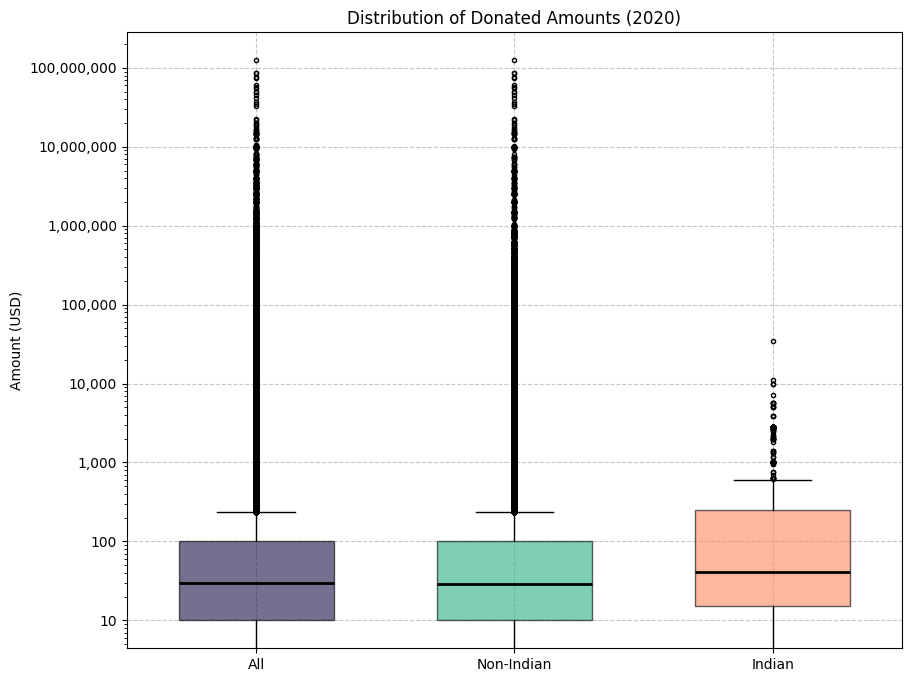

In [25]:
plt.figure(figsize=(10, 8))
plot = plt.boxplot([amounts_all, amounts_non_indian, amounts_indian], tick_labels=["All", "Non-Indian", "Indian"], patch_artist=True, widths=0.6, medianprops={"color": "black", "linewidth": 2}, flierprops={"marker": "o", "markersize": 3})

colors = ["#1b1044", "#2ab07f", "#fb8761"]
for patch, color in zip(plot["boxes"], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

plt.title("Distribution of Donated Amounts (2020)")
plt.ylabel("Amount (USD)")
plt.yscale("log")
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

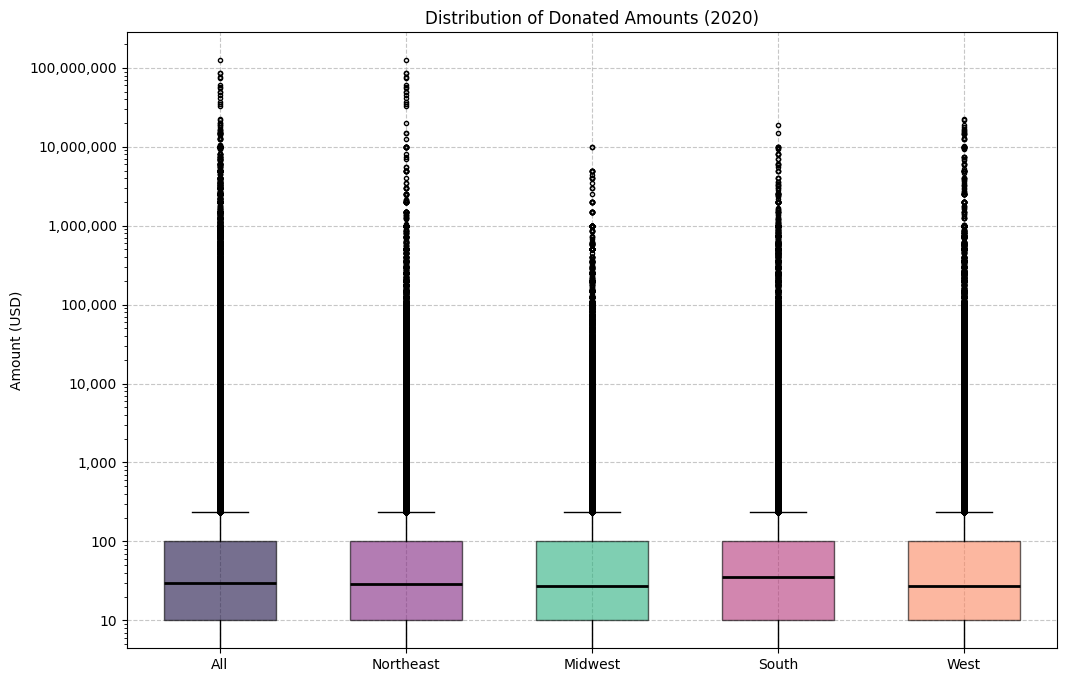

In [26]:
plt.figure(figsize=(12, 8))
plot = plt.boxplot(amounts, tick_labels=["All"] + regions, patch_artist=True, widths=0.6, medianprops={"color": "black", "linewidth": 2}, flierprops={"marker": "o", "markersize": 3})

colors = ["#1b1044", "#812581", "#2ab07f", "#b5367a", "#fb8761"]
for patch, color in zip(plot["boxes"], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

plt.title("Distribution of Donated Amounts (2020)")
plt.ylabel("Amount (USD)")
plt.yscale("log")
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

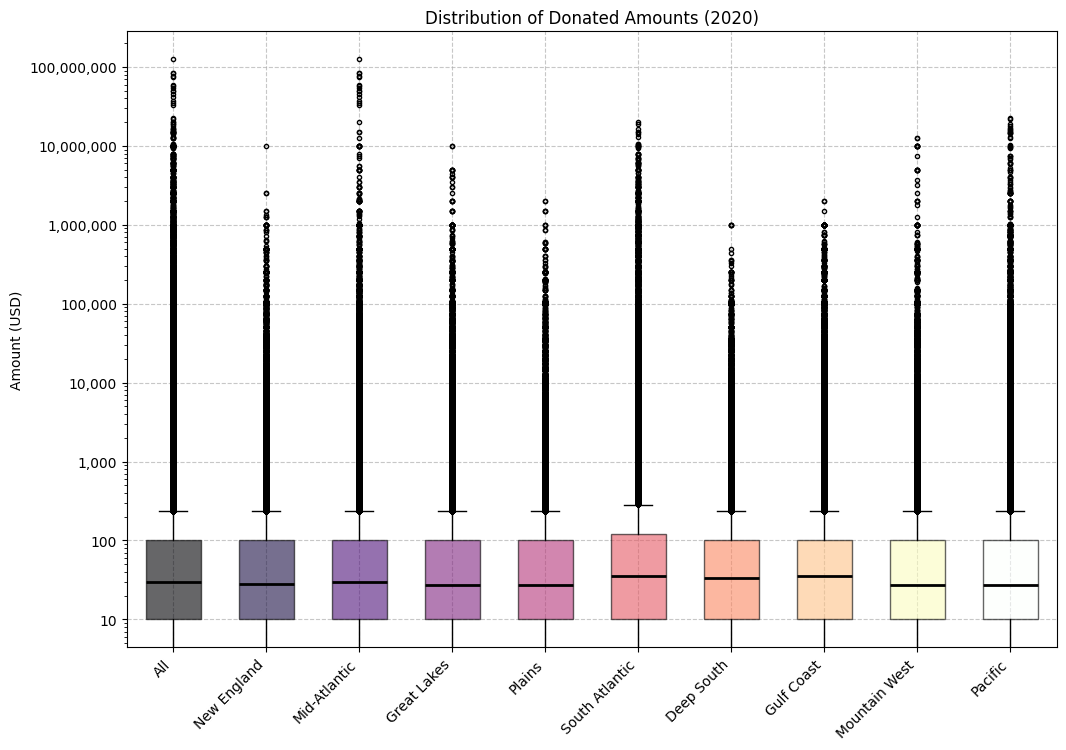

In [27]:
plt.figure(figsize=(12, 8))
plot = plt.boxplot(census_amounts, tick_labels=["All"] + census_regions, patch_artist=True, widths=0.6, medianprops={"color": "black", "linewidth": 2}, flierprops={"marker": "o", "markersize": 3})

colors = ["#000004", "#1b1044", "#4f127b", "#812581", "#b5367a", "#e55964", "#fb8761", "#fec287", "#fbfdbf", "#fcfffd"]
for patch, color in zip(plot["boxes"], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

plt.title("Distribution of Donated Amounts (2020)")
plt.ylabel("Amount (USD)")
plt.yscale("log")
plt.xticks(rotation=45, ha='right')
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

C:\Users\karnav\AppData\Local\Temp\ipykernel_21560\2497341411.py:12: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, 1000)


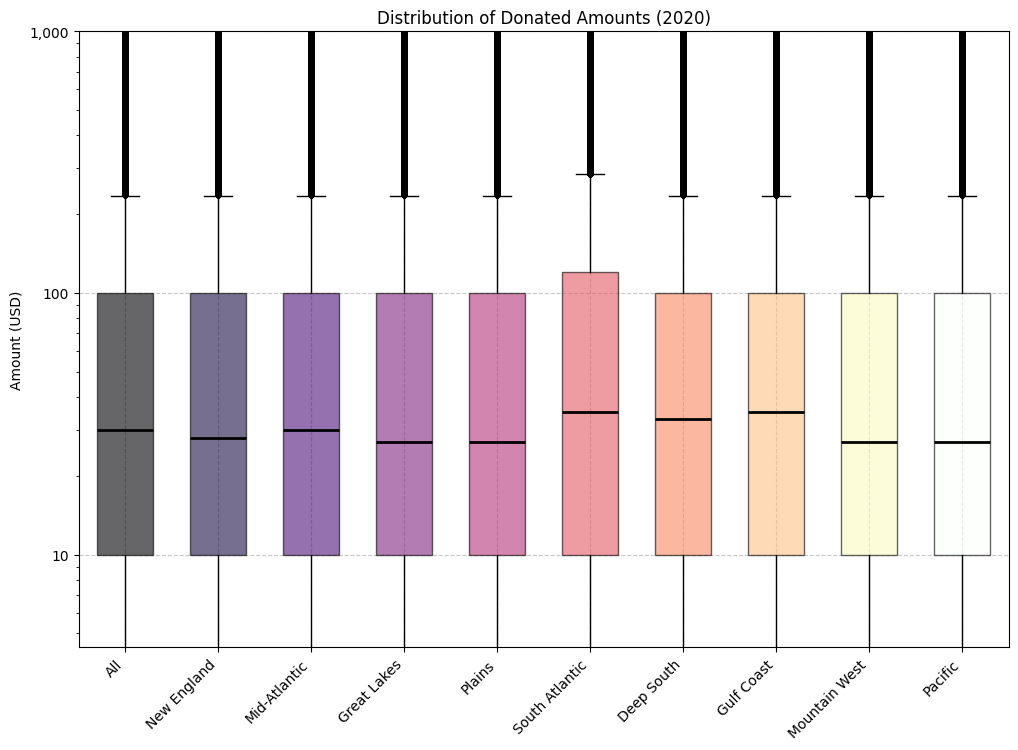

In [28]:
plt.figure(figsize=(12, 8))
plot = plt.boxplot(census_amounts, tick_labels=["All"] + census_regions, patch_artist=True, widths=0.6, medianprops={"color": "black", "linewidth": 2}, flierprops={"marker": "o", "markersize": 3})

colors = ["#000004", "#1b1044", "#4f127b", "#812581", "#b5367a", "#e55964", "#fb8761", "#fec287", "#fbfdbf", "#fcfffd"]
for patch, color in zip(plot["boxes"], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

plt.title("Distribution of Donated Amounts (2020)")
plt.ylabel("Amount (USD)")
plt.yscale("log")
plt.ylim(0, 1000)
plt.xticks(rotation=45, ha='right')
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

In [29]:
state_stats = (
    df.group_by("state")
    .agg(
        pl.col("amount").mean().alias("avg_amount"),
        pl.col("amount").median().alias("med_amount"),
        pl.col("amount").count().alias("total_donations"),
        pl.col("amount").filter(pl.col("is_indian")).mean().alias("avg_amount_indian"),
        pl.col("amount").filter(pl.col("is_indian")).median().alias("med_amount_indian"),
        pl.col("amount").filter(pl.col("is_indian")).count().alias("indian_donations")
    )
    .sort("avg_amount", descending=True)
)

In [30]:
import geopandas as gpd

# Load U.S. states geometry (Natural Earth dataset)
url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_1_states_provinces.zip"
gdf = gpd.read_file(url)

exclude_codes = ["US-AK", "US-HI", "US-PR", "US-GU", "US-VI", "US-AS", "US-MP"]
gdf = gdf[(gdf["iso_a2"] == "US") & (~gdf["iso_3166_2"].isin(exclude_codes))][["iso_3166_2", "name", "geometry"]]
gdf["state"] = gdf["iso_3166_2"].str.replace("US-", "")
gdf_merged = gdf.merge(state_stats.to_pandas(), on="state", how="left")

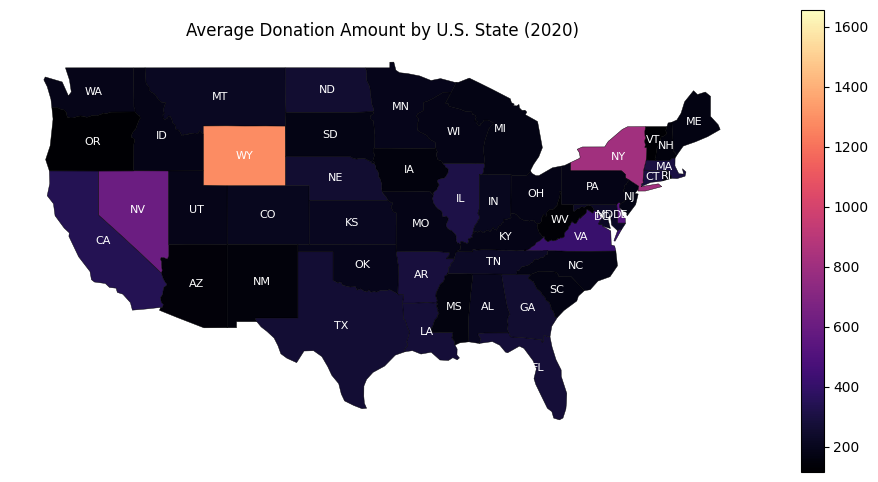

In [31]:
fig, ax = plt.subplots(figsize=(12, 6))
gdf_merged.plot(
    column="avg_amount",
    cmap="magma",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"}
)

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")

plt.title("Average Donation Amount by U.S. State (2020)")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

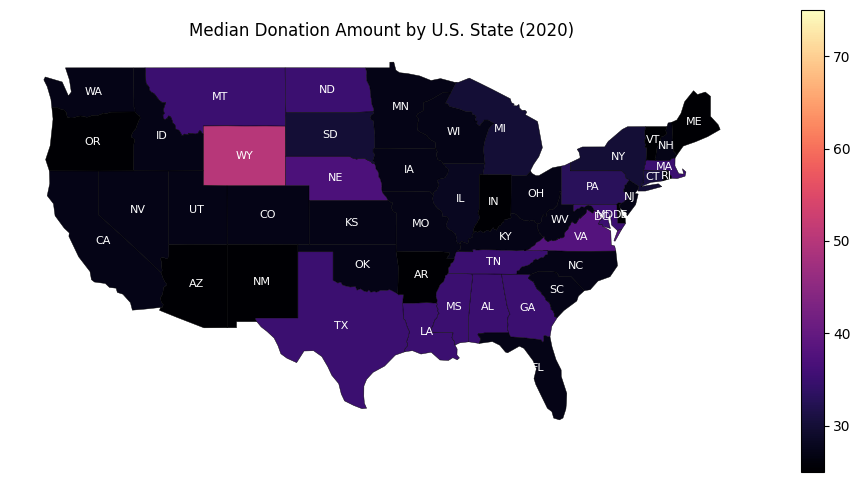

In [32]:
fig, ax = plt.subplots(figsize=(12, 6))
gdf_merged.plot(
    column="med_amount",
    cmap="magma",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"}
)

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")

plt.title("Median Donation Amount by U.S. State (2020)")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

In [33]:
print(df.filter(pl.col("state") == "WY").sort("amount", descending=True))

shape: (63_697, 10)
┌────────────┬────────────┬───────────┬───────────┬───┬───────────┬───────────┬────────┬───────────┐
│ contrib_id ┆ name       ┆ recip_id  ┆ amount    ┆ … ┆ recipcode ┆ is_indian ┆ region ┆ census_re │
│ ---        ┆ ---        ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---    ┆ gion      │
│ str        ┆ str        ┆ str       ┆ f64       ┆   ┆ str       ┆ bool      ┆ str    ┆ ---       │
│            ┆            ┆           ┆           ┆   ┆           ┆           ┆        ┆ str       │
╞════════════╪════════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪════════╪═══════════╡
│ U000000468 ┆ MELLON,    ┆ C00637512 ┆ 1e7       ┆ … ┆ OI        ┆ false     ┆ West   ┆ Mountain  │
│ 41         ┆ TIMOTHY    ┆           ┆           ┆   ┆           ┆           ┆        ┆ West      │
│ U000000468 ┆ MELLON,    ┆ C00504530 ┆ 1e7       ┆ … ┆ OI        ┆ false     ┆ West   ┆ Mountain  │
│ 41         ┆ TIMOTHY    ┆           ┆           ┆   ┆           ┆    

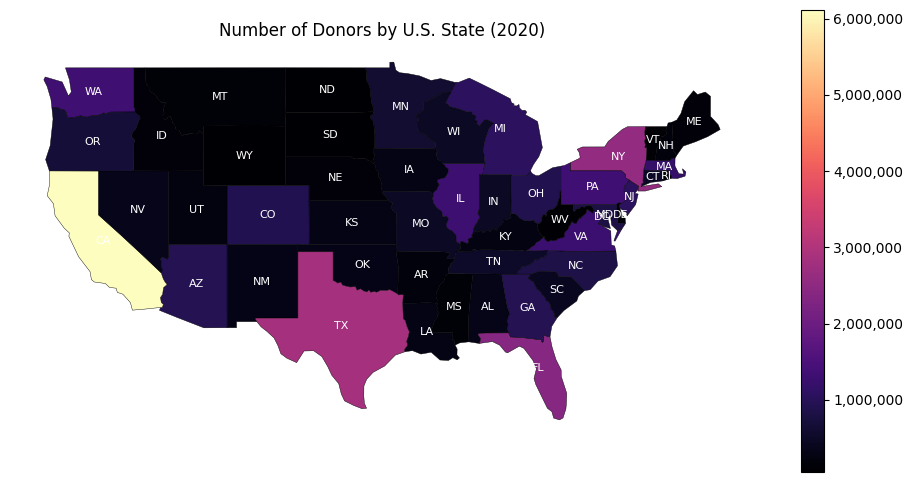

In [34]:
fig, ax = plt.subplots(figsize=(12, 6))
gdf_merged.plot(
    column="total_donations",
    cmap="magma",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"}
)

cbar = fig.axes[-1]
cbar.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:,.0f}"))

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")

plt.title("Number of Donors by U.S. State (2020)")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

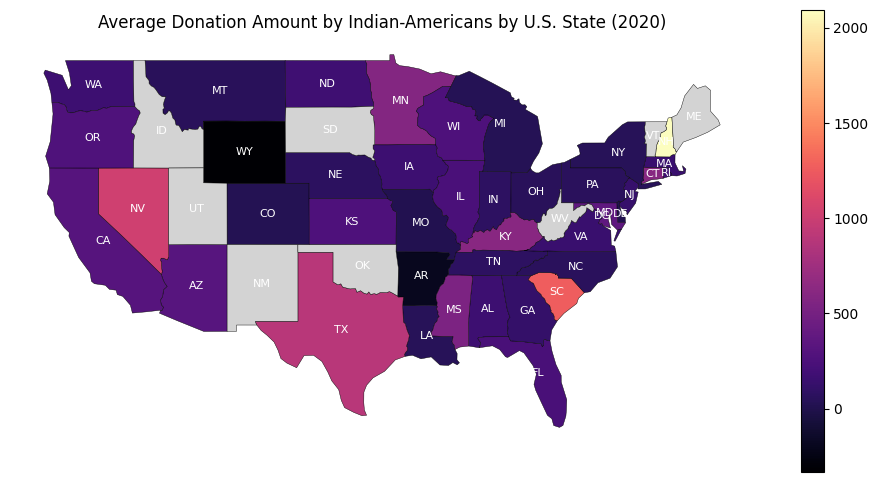

In [35]:
fig, ax = plt.subplots(figsize=(12, 6))
gdf_merged.plot(
    column="avg_amount_indian",
    cmap="magma",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"}
)

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")

plt.title("Average Donation Amount by Indian-Americans by U.S. State (2020)")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

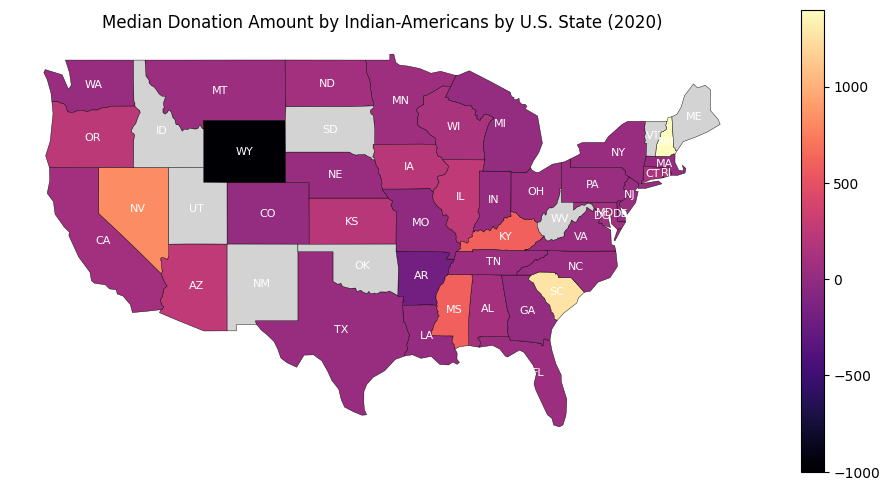

In [36]:
fig, ax = plt.subplots(figsize=(12, 6))
gdf_merged.plot(
    column="med_amount_indian",
    cmap="magma",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"}
)

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")

plt.title("Median Donation Amount by Indian-Americans by U.S. State (2020)")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

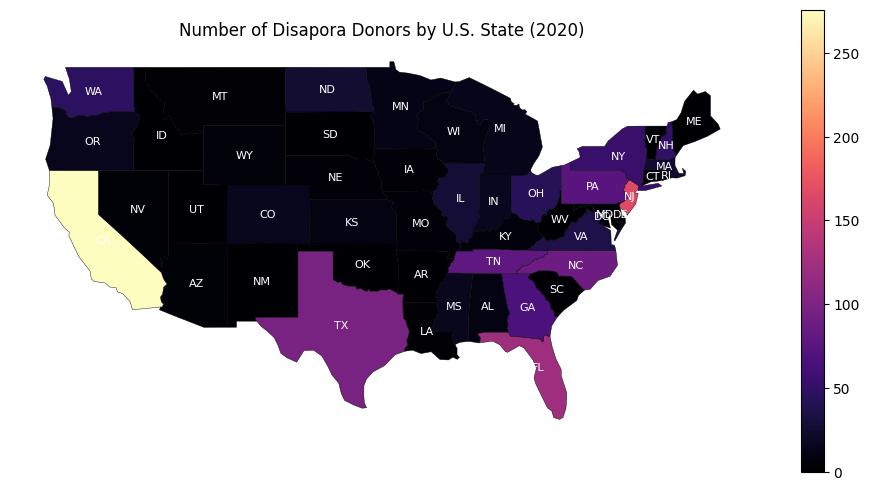

In [37]:
fig, ax = plt.subplots(figsize=(12, 6))
gdf_merged.plot(
    column="indian_donations",
    cmap="magma",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"}
)

cbar = fig.axes[-1]
cbar.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:,.0f}"))

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")

plt.title("Number of Disapora Donors by U.S. State (2020)")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()